In [ ]:
!pip install timm
!pip install -q transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time

import cv2
import numpy as np
import timm
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import (Compose, Normalize, RandomHorizontalFlip,
                                    RandomResizedCrop, RandomRotation, Resize, ToTensor)
from tqdm.notebook import tqdm

# **2. Load and Visualize Dataset**

In [ ]:
# we can load a custom dataset using the "imagefolder" feature

train_dataset = load_dataset("imagefolder", data_files = "/content/drive/MyDrive/shutter_service/shutter_data_individual_zips/without_person/new_data/train.zip")
test_dataset = load_dataset("imagefolder", data_files = "/content/drive/MyDrive/shutter_service/shutter_data_individual_zips/without_person/new_data/test.zip")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-c58032de264ec35b/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-c8784c1b750f6b61/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1689
    })
})

In [ ]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 193
    })
})

In [ ]:
train_dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=2, names=['shutter_down', 'shutter_up'], id=None)}

In [ ]:
labels = train_dataset["train"].features["label"].names
print(labels)
print(len(labels))

['shutter_down', 'shutter_up']
2


In [ ]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'shutter_down', 1: 'shutter_up'}


Label: 1
Image Size: (352, 288)


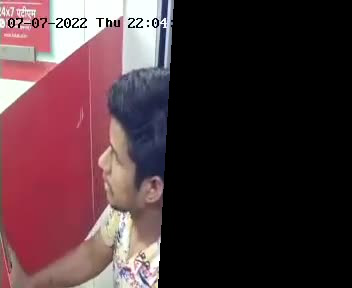

In [ ]:
example = train_dataset["train"][500]
print(f"Label: {train_dataset['train'][500]['label']}")
print(f"Image Size: {example['image'].size}")
example["image"]

# **3. Process Data**

In [ ]:
normalize = Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

transform = Compose([
     Resize((50,50)),
     RandomHorizontalFlip(),
     RandomRotation(degrees=30),
     ToTensor(),
     normalize
    ])

def train_transforms(examples):
  examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]

  return examples

In [ ]:
train_processed_dataset = train_dataset.with_transform(train_transforms)
train_processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 50, 50])

In [ ]:
test_processed_dataset = test_dataset.with_transform(train_transforms)
test_processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 50, 50])

In [ ]:
train_processed_dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=352x288 at 0x7F2EA7247550>,
 'label': 1,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ...,  1.7865, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.0458, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ...,  2.0784, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -1.0378, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, 

In [ ]:
test_processed_dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=352x288 at 0x7F2EA84DDED0>,
 'label': 1,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, 

In [ ]:
def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
train_dataloader = DataLoader(train_processed_dataset["train"], collate_fn = collate_fn, batch_size = 16, shuffle = True)

batch = next(iter(train_dataloader))
for k, v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([16, 3, 50, 50])
labels torch.Size([16])


In [ ]:
test_dataloader = DataLoader(test_processed_dataset["train"], collate_fn = collate_fn, batch_size = 16, shuffle = False)

batch = next(iter(test_dataloader))
for k, v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([16, 3, 50, 50])
labels torch.Size([16])


#**4. Model Definition**

In [ ]:
timm.list_models('convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_hnf',
 'convnext_nano_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [ ]:
model = timm.create_model('convnext_nano', pretrained = True, num_classes = 2)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_nano_d1h-7eb4bdea.pth" to /root/.cache/torch/hub/checkpoints/convnext_nano_d1h-7eb4bdea.pth


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 80, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
          (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
          (mlp): ConvMlp(
            (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))
            (norm): Identity()
            (act): GELU(approximate=none)
            (drop): Dropout(p=0.0, inplace=False)
            (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
          (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affin

# **5. Model Training**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
best_test_acc = 0

In [ ]:
def save_best_weights(model, pres_val_acc, best_val_acc):
    if pres_val_acc > best_val_acc:
        best_val_acc = pres_val_acc
        torch.save({'state_dict': model.state_dict()}, '/content/drive/MyDrive/shutter_service/timm_convnext50(wo_person)_best.pt')

    return best_val_acc

In [ ]:
for epoch in range(25):
    
    print("Epoch:", epoch)

    # training phase
    model.train()
    train_correct = 0
    train_total = 0

    for idx, batch in enumerate(train_dataloader):

        # move batch to GPU
        batch = {k:v.to(device) for k,v in batch.items()}

        # forward pass
        optimizer.zero_grad()
        outputs = model(batch["pixel_values"])
        labels = batch["labels"]
        train_loss = criterion(outputs, labels)

        train_loss.backward()
        optimizer.step()

        # metrics
        train_total += batch["labels"].shape[0]
        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == batch["labels"]).sum().item()

        train_accuracy = train_correct / train_total

        if idx % 100 == 0:
            print(f"Train Loss after {idx} steps:", train_loss.item())
            print(f"Train Accuracy after {idx} steps:", train_accuracy)
            print()


    # validation phase
    model.eval()
    test_correct = 0
    test_total = 0
    for idx, batch in enumerate(test_dataloader):

        # move batch to GPU
        batch = {k:v.to(device) for k,v in batch.items()}

        # forward pass
        optimizer.zero_grad()
        outputs = model(batch["pixel_values"])
        labels = batch["labels"]
        test_loss = criterion(outputs, labels)

        # metrics
        test_total += batch["labels"].shape[0]
        test_predicted = outputs.argmax(-1)
        test_correct += (test_predicted == batch["labels"]).sum().item()

        test_accuracy = test_correct / test_total
    

        if idx % 100 == 0:
            print(f"Val Loss after {idx} steps:", test_loss.item())
            print(f"Val Accuracy after {idx} steps:", test_accuracy)


    best_test_acc = save_best_weights(model, test_accuracy, best_test_acc)

    print()
    print('-------------------------------------------------------------')
    print()

Epoch: 0
Train Loss after 0 steps: 0.035729531198740005
Train Accuracy after 0 steps: 1.0

Train Loss after 100 steps: 0.20229710638523102
Train Accuracy after 100 steps: 0.9820544554455446

Val Loss after 0 steps: 1.19829261302948
Val Accuracy after 0 steps: 0.8125

-------------------------------------------------------------

Epoch: 1
Train Loss after 0 steps: 0.04305462911725044
Train Accuracy after 0 steps: 1.0

Train Loss after 100 steps: 0.005106710363179445
Train Accuracy after 100 steps: 0.9851485148514851

Val Loss after 0 steps: 0.14116062223911285
Val Accuracy after 0 steps: 0.9375

-------------------------------------------------------------

Epoch: 2
Train Loss after 0 steps: 0.025249028578400612
Train Accuracy after 0 steps: 1.0

Train Loss after 100 steps: 0.00978167075663805
Train Accuracy after 100 steps: 0.9931930693069307

Val Loss after 0 steps: 0.005754692945629358
Val Accuracy after 0 steps: 1.0

-------------------------------------------------------------

Epo

In [ ]:
torch.save({'state_dict': model.state_dict()}, '/content/drive/MyDrive/shutter_service/timm_convnext50(wo_person)_last.pt')

In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/shutter_service/model_weights.pt')
# model.load_state_dict(checkpoint['state_dict'])